# Comparing Simple Models for a Baseline

Importing Libraries

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

Loading Dataset

In [ ]:
 # Uploading the dataset
file_path = '/content/StudentPerformanceFactors.csv'
student_data1 = pd.read_csv(file_path)


student_data = student_data1.drop(columns=['Previous_Scores'])
student_data.describe()
student_data.info()
#separating features and target
X = student_data.drop(columns=['Exam_Score'])
y = student_data['Exam_Score']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Motivation_Level            6607 non-null   object
 7   Internet_Access             6607 non-null   object
 8   Tutoring_Sessions           6607 non-null   int64 
 9   Family_Income               6607 non-null   object
 10  Teacher_Quality             6529 non-null   object
 11  School_Type                 6607 non-null   object
 12  Peer_Influence              6607 non-null   object
 13  Physical_Activity           6607 non-null   int6

Separate Target Variable

In [ ]:
X = student_data.drop(columns=['Exam_Score'])
y = student_data['Exam_Score']

Identifying Feature Types

In [ ]:
numeric_features = ['Hours_Studied', 'Attendance', 'Sleep_Hours',
                    'Tutoring_Sessions', 'Physical_Activity']

ordinal_features = [
    'Parental_Involvement',
    'Access_to_Resources',
    'Motivation_Level',
    'Family_Income',
    'Teacher_Quality',
    'Distance_from_Home',
    'Peer_Influence'
]

ordinal_categories = [                  #Features:
    ['Low', 'Medium', 'High'],          #Parental_Involvement
    ['Low', 'Medium', 'High'],          #Access_to_Resources
    ['Low', 'Medium', 'High'],          #Motivation_Level
    ['Low', 'Medium', 'High'],          #Family_Income
    ['Low', 'Medium', 'High'],          #Teacher_Quality
    ['Near', 'Moderate', 'Far'],        #Distance_from_Home
    ['Negative','Neutral','Positive']   #Peer_Influence
]

nominal_features = [
    'Extracurricular_Activities',
    'Internet_Access',
    'School_Type',
    'Learning_Disabilities',
    'Gender',
    'Parental_Education_Level'
]

Preprocess data. Handle missing values, encoding, and scaling.

In [ ]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_enc', OrdinalEncoder(categories=ordinal_categories))
])

nominal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('ord', ordinal_pipeline, ordinal_features),
    ('nom', nominal_pipeline, nominal_features)
], remainder='drop')

Train / Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaling Target

In [ ]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

Defining and Training different models

In [ ]:
from sklearn.neural_network import MLPRegressor

#Define Models
models = {
    'Ridge': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'MLP': MLPRegressor(random_state=42, max_iter=500)
}

results = {}


#train Each Model & Evaluate (With Target Scaling)
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    #Fitting on scaled y
    pipeline.fit(X_train, y_train_scaled)
    #Predicting (scaled)
    y_pred_scaled = pipeline.predict(X_test)

    #Inverse-transform predictions to original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    #Evaluating metrics on original y_test
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R²': r2, 'pipeline': pipeline}


Results and Evaluationn

Model Comparison:
                        MSE       MAE        R²
Ridge              3.714993  0.786874  0.737179
Random Forest      4.769224   1.18171  0.662596
Gradient Boosting  4.127458  0.951802  0.707999
XGBoost            5.143936  1.187164  0.636087
MLP                5.042016  1.172507  0.643297


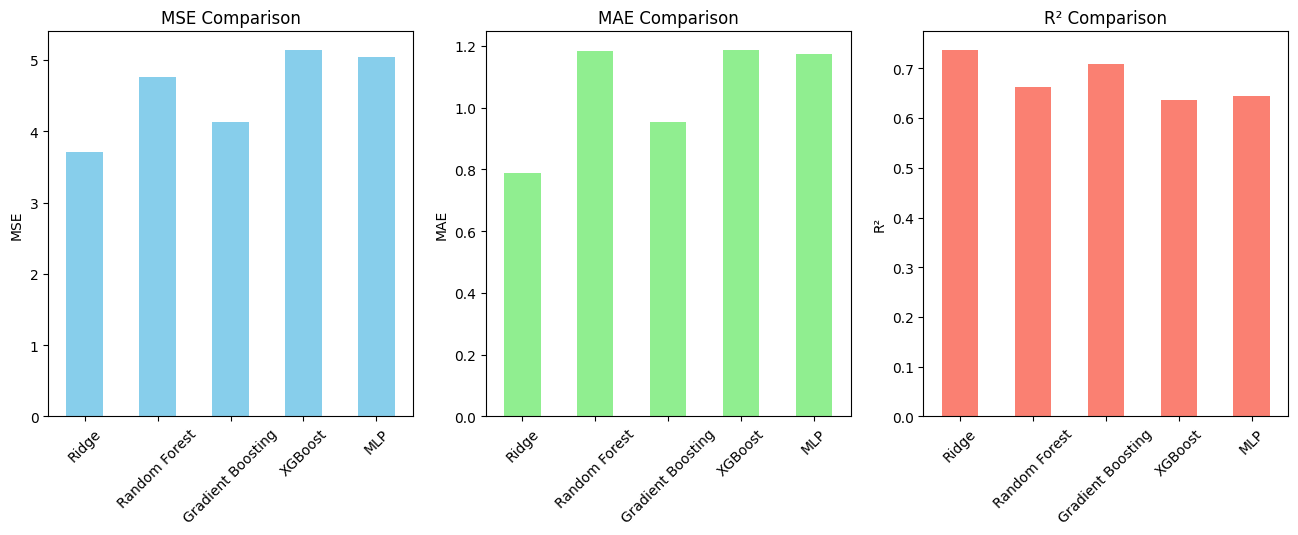

In [ ]:

#Evaluating the models and create the results datframe
results_df = pd.DataFrame(results).T
print("Model Comparison:")
print(results_df[['MSE', 'MAE', 'R²']])
#Plotting MSE, MAE, R^2 in separate subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

# First the MSE subplot
results_df['MSE'].plot(
    kind='bar',
    ax=axes[0],
    color='skyblue',
    title='MSE Comparison'
)
axes[0].set_ylabel('MSE')
axes[0].tick_params(axis='x', rotation=45)

#MAE subplot
results_df['MAE'].plot(
    kind='bar',
    ax=axes[1],
    color='lightgreen',
    title='MAE Comparison'
)
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

#R^2
results_df['R²'].plot(
    kind='bar',
    ax=axes[2],
    color='salmon',
    title='R² Comparison'
)
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

plt.show()

# Hypertuning Models

In [ ]:
#Now to hypertune the models:
#Creating the hyperparameter grids
param_grids = {
    'Ridge': {
        'model__alpha': [0.001, 0.01, 0.1, 1.0, 10, 100]
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 5, 10],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'MLP': {
        'model__hidden_layer_sizes': [(64,), (64,64)],
        'model__alpha': [0.0001, 0.001, 0.01],
        'model__learning_rate_init': [0.001, 0.01]
    }
}

tuned_results = {}

print("\n--- Starting Hyperparameter Tuning ---\n")
for name, base_model in models.items():
    print(f"Hyperparameter tuning for {name}...")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', base_model)
    ])

    param_grid = param_grids[name]

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    #Fit on X_train & y_train_scaled
    grid_search.fit(X_train, y_train_scaled)

    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_

    #predict (scaled)
    y_pred_scaled = best_pipeline.predict(X_test)
    #Inverse transform to original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    tuned_results[name] = {
        'Best Params': best_params,
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'Best Pipeline': best_pipeline
    }



--- Starting Hyperparameter Tuning ---

Hyperparameter tuning for Ridge...
Hyperparameter tuning for Random Forest...
Hyperparameter tuning for Gradient Boosting...
Hyperparameter tuning for XGBoost...
Hyperparameter tuning for MLP...


Model Comparison:
                        MSE       MAE        R²
Ridge              3.714279  0.786998   0.73723
Random Forest      4.713276  1.169869  0.666555
Gradient Boosting  4.025167  0.896273  0.715235
XGBoost            4.063597  0.906476  0.712517
MLP                 4.48051   1.04073  0.683022


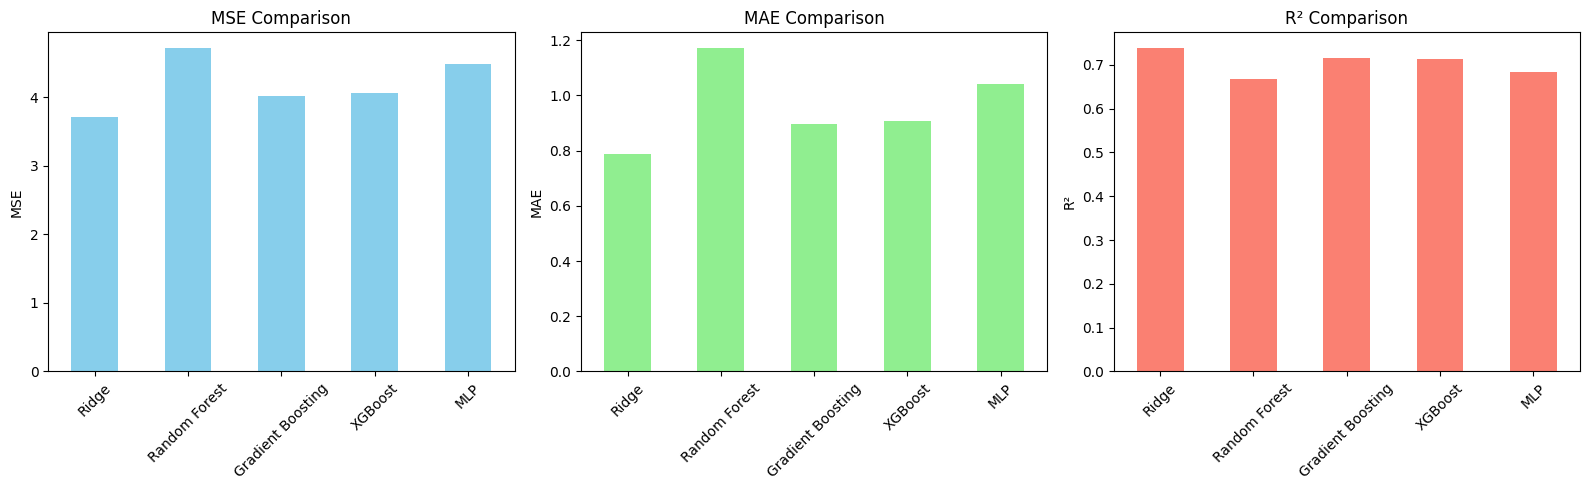

In [ ]:
# Evaluating the models and create results dataframe again

results_df = pd.DataFrame(tuned_results).T
print("Model Comparison:")
print(results_df[['MSE', 'MAE', 'R²']])

#Plot MSE, MAE, R^2 in separate subplots

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

#MSE
results_df['MSE'].plot(
    kind='bar',
    ax=axes[0],
    color='skyblue',
    title='MSE Comparison'
)
axes[0].set_ylabel('MSE')
axes[0].tick_params(axis='x', rotation=45)

#MAE
results_df['MAE'].plot(
    kind='bar',
    ax=axes[1],
    color='lightgreen',
    title='MAE Comparison'
)
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# R^2
results_df['R²'].plot(
    kind='bar',
    ax=axes[2],
    color='salmon',
    title='R² Comparison'
)
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)


plt.show()

# Feature Importance from Best performing Model

Best model: Ridge
Top 6 most important features: ['Attendance', 'Hours_Studied', 'Access_to_Resources', 'Parental_Involvement', 'Internet_Access_Yes', 'Learning_Disabilities_Yes']


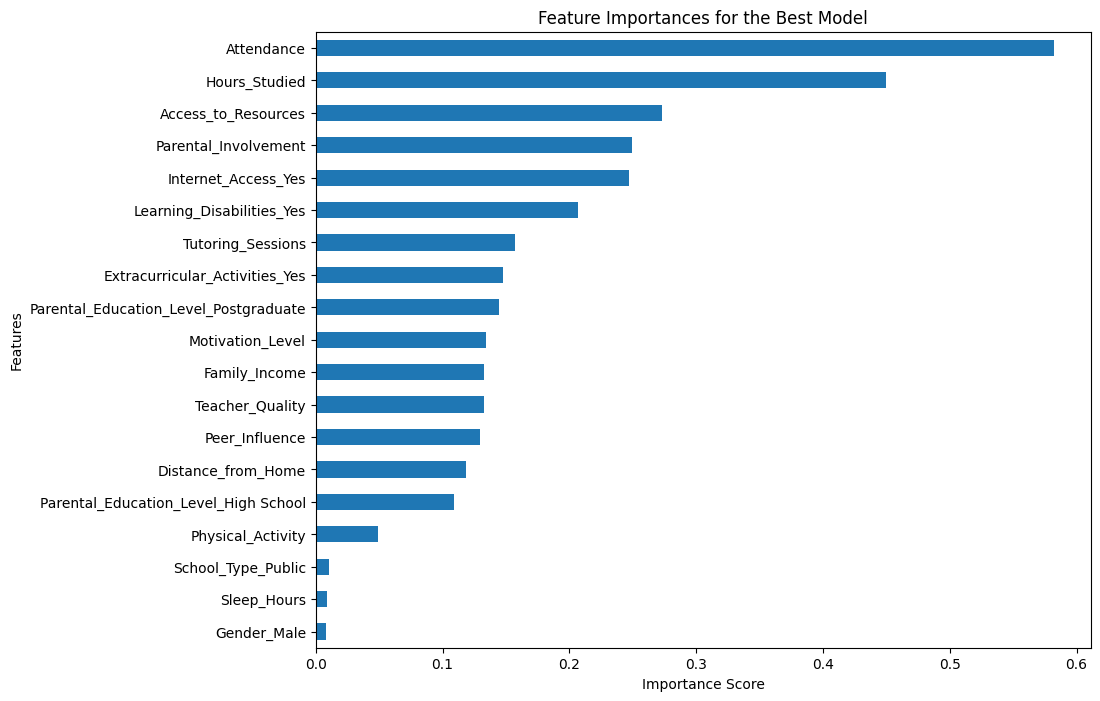

In [ ]:
# select the Best Model (based on tuned results)
best_model_name = results_df['R²'].idxmax()
best_pipeline = results[best_model_name]['pipeline']
print(f"Best model: {best_model_name}")

#Identifying the top 6 best features from the best Model
preprocessor_fit = best_pipeline.named_steps['preprocessor'].fit(X_train, y_train_scaled)
onehot = preprocessor_fit.named_transformers_['nom']
nominal_expanded = onehot.get_feature_names_out(nominal_features)

all_feature_names = numeric_features + ordinal_features + list(nominal_expanded)

best_estimator = best_pipeline.named_steps['model']

importances = np.abs(best_estimator.coef_)

feature_importances = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
top_6_features = feature_importances.head(6).index.tolist()
print("Top 6 most important features:", top_6_features)

#Plotting the feature importances
plt.figure(figsize=(10, 8))
feature_importances.plot(kind='barh')
plt.title("Feature Importances for the Best Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()  #Makes sure the top feature is on the top
plt.show()

# Using the model to predict class percentile

Gathering data from new student

In [ ]:
def gather_student_data(include_hours_attendance=True):
    """
    Gathers data from the user about a new student.
    Returns:
        pd.DataFrame: A single-row DataFrame containing the collected features.
    """
    print("\n    Collecting Student Features    \n")

    data_dict = {}

    if include_hours_attendance:
        #Numeric features for hours and attendance
        hours_studied = float(input("Enter the number of hours studied per week (e.g., 8.5): "))
        attendance = float(input("Enter the attendance percentage (0-100): "))
        data_dict['Hours_Studied'] = [hours_studied]
        data_dict['Attendance'] = [attendance]
    else:
        pass

    #Collect remaining numeric features
    sleep_hours = float(input("Enter the average number of hours of sleep per day (e.g., 7): "))
    tutoring_sessions = float(input("Enter the number of tutoring sessions per week (e.g., 2): "))
    physical_activity = float(input("Enter the number of hours of physical activity per week (e.g., 3): "))

    # Collect ordinal features
    parental_involvement = input("Enter Parental Involvement (Low, Medium, High): ")
    access_to_resources = input("Enter Access to Resources (Low, Medium, High): ")
    motivation_level = input("Enter Motivation Level (Low, Medium, High): ")
    family_income = input("Enter Family Income (Low, Medium, High): ")
    teacher_quality = input("Enter Teacher Quality (Low, Medium, High): ")
    distance_from_home = input("Enter Distance from Home (Near, Moderate, Far): ")
    peer_influence = input("Enter Peer Influence (Negative, Neutral, Positive): ")

    #Collect nominal features
    extracurricular_activities = input("Enter Extracurricular Activities (Yes, No): ")
    internet_access = input("Enter Internet Access (Yes, No): ")
    school_type = input("Enter School Type (Public, Private): ")
    learning_disabilities = input("Enter Learning Disabilities (Yes, No): ")
    gender = input("Enter Gender (Male, Female): ")
    parental_education_level = input("Enter Parental Education Level (HighSchool, College, Postgraduate): ")

    #Update data_dict with the rest of the features
    data_dict.update({
        'Sleep_Hours': [sleep_hours],
        'Tutoring_Sessions': [tutoring_sessions],
        'Physical_Activity': [physical_activity],
        'Parental_Involvement': [parental_involvement],
        'Access_to_Resources': [access_to_resources],
        'Motivation_Level': [motivation_level],
        'Family_Income': [family_income],
        'Teacher_Quality': [teacher_quality],
        'Distance_from_Home': [distance_from_home],
        'Peer_Influence': [peer_influence],
        'Extracurricular_Activities': [extracurricular_activities],
        'Internet_Access': [internet_access],
        'School_Type': [school_type],
        'Learning_Disabilities': [learning_disabilities],
        'Gender': [gender],
        'Parental_Education_Level': [parental_education_level]
    })

    new_student = pd.DataFrame(data_dict)
    return new_student

Predicting percentile

In [ ]:
def predict_new_student_percentile(best_pipeline, scaler_y, student_data, gather_function):
    """
    Gathers new student data using the specified gather function,
    and then predicts the exam score using best pipeline, and computes the percentile
    compared to all existing exam scores in the student data.


    Parameters:
    best_pipeline :
        The trained pipeline (with preprocessing + final model).
    scaler_y :
        The fitted scaler used for the target variable (Exam_Score).
    student_data :
        The dataset containing the 'Exam_Score' column to compute percentiles.
    gather_function :
        A function that gathers user input and returns a single-row DataFrame


    Returns:
      None. It prints the percentile
    """
    #Gather student data in a single-row dataframe
    new_student = gather_function()

    #Predict exam score (scaled)
    predicted_score_scaled = best_pipeline.predict(new_student)
    #Inverse-transform to original scale
    predicted_score = scaler_y.inverse_transform(predicted_score_scaled.reshape(-1, 1)).ravel()[0]

    #Compute percentile relative to the entire dataset
    all_scores = student_data['Exam_Score'].values
    percentile = (np.sum(all_scores <= predicted_score) / len(all_scores)) * 100

    print(f"You are predicted to be in the {percentile:.2f}th percentile of your class on this exam.")

    return


# Using the model to predict attendance and hours studied required to achieve wanted percentile

Function that computes attendence and study hours necessary for achieving percentile goal

In [ ]:
def compute_just_enough_attendance_hours(
    pipeline,
    scaler_y,
    student_data_df,
    hours_range=None,
    gather_fn=None
):
    """
    Prompts the user for the desired percentile and collects their base features
    (excluding Hours_Studied and Attendance) via gather_student_data(include_hours_attendance=False),
    then checks 7 attendance levels [100, 95, 90, 85, 80, 75, 70].
    And then for each attendance, it iterates over hours_range to find the minimum hours studied
    to reach or exceed their target percentile.

    Parameters:
    pipeline :
        The trained pipeline (e.g. best_pipeline) that includes preprocessing & final model.
    scaler_y :
        The fitted scaler for the target variable (Exam_Score).
    student_data_df :
        The original dataset containing 'Exam_Score' (used for percentile calculation).
    hours_range :
        A list or range of possible hours studied to check. Default: range(0, 13).
    gather_fn :
        A function to gather the student's base features. Default uses gather_student_data(include_hours_attendance=False).

    Returns:
    None
        Prints the results or "No combinations possible" message.
    """
    # First asking the user for the target percentile
    target_percentile = float(input("\nEnter the target percentile you want to achieve (0-100): "))

    #defining the attendance levels to check
    attendance_levels = [100, 95, 90, 85, 80, 75, 70]

    #Define the default hours_range if not provided
    if hours_range is None:
        hours_range = range(0, 36)

    #Gather the student's base features (excluding Hours_Studied, Attendance)
    #    If no gather_fn provided, default to gather_student_data with include_hours_attendance=False
    if gather_fn is None:
        gather_fn = lambda: gather_student_data(include_hours_attendance=False)

    base_features_df = gather_fn()

    #Prepare for percentile calculation
    all_scores = student_data_df['Exam_Score'].values
    n = len(all_scores)
    found_combos = []

    #For each attendance level, find the "just enough" combination
    for attendance in attendance_levels:
        best_combo = None
        best_diff = None  # track how far above the target percentile we are

        for h in hours_range:
            temp_df = base_features_df.copy()
            temp_df['Hours_Studied'] = [h]
            temp_df['Attendance'] = [attendance]

            # Predict exam score
            y_pred_scaled = pipeline.predict(temp_df)
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()[0]

            # Calculate empirical percentile
            percentile = (np.sum(all_scores <= y_pred) / n) * 100.0
            percentile_diff = percentile - target_percentile

            # Among combos meeting or exceeding the target, pick the closest above target
            if percentile >= target_percentile:
                if best_diff is None or percentile_diff < best_diff:
                    best_diff = percentile_diff
                    best_combo = {
                        'Attendance': attendance,
                        'Hours_Studied': h,
                        'Predicted_Score': y_pred,
                        'Percentile': percentile
                    }

        if best_combo is not None:
            found_combos.append(best_combo)

    #printing final results to the user
    if len(found_combos) == 0:
        print(f"\nNo combinations possible to reach at least the {target_percentile:.2f}th percentile.\n")
        return

    combos_df = pd.DataFrame(found_combos).sort_values(by='Attendance', ascending=False).reset_index(drop=True)

    print(f"\nCombinations (up to 7 total) that are just enough to reach or exceed the {target_percentile:.2f}th percentile:\n")
    print(combos_df)

# Testing User Interaction

Predicting class percentile example

In [ ]:
predict_new_student_percentile(
    best_pipeline=best_pipeline,
    scaler_y=scaler_y,
    student_data=student_data,
    gather_function=lambda: gather_student_data(include_hours_attendance=True)
)


--- Collecting Student Features ---



Predicting attendence and hours studied combination

In [ ]:
compute_just_enough_attendance_hours(
    pipeline=best_pipeline,
    scaler_y=scaler_y,
    student_data_df=student_data
)